# <font color="#ff00ff">Agentic RAG System Using ReAct Paradigm</font>

<font color="blue"> Learn how to build an **Agentic RAG System** to chat with Financial Reports such as 10k using **ReAct Agent** </font>

* Built a ReAct agent using LlamaIndex’s ReActAgent to answer financial comparison questions using retrieval + reasoning.

* Two Query Engines are used as tools: one for Apple’s 2024 financials, the other for Nvidia’s — each tied to their respective document indexes.

* Agent uses OpenAI’s GPT-4o-mini, with tool-calling enabled via the QueryEngineTool, allowing dynamic retrieval before reasoning.

* Asked complex financial questions, like comparing 2024 vs. 2023 revenues, and Apple’s vs. Nvidia’s revenues.

* Agent follows ReAct paradigm: identifies tool use if needed, fetches relevant context, and responds with calculated insights (e.g., % increase, ratio comparisons).

# Technical Stack

* LlamaIndex:  https://docs.llamaindex.ai/en/stable/examples/agent/agent_workflow_basic/

# <font color="blue"> Agentic RAG </font>

* Before starting building this agentic RAG system with a ReAct agent, let's have a look on what does mean ReAct Paradigm:

✅ ReAct means <font color="blue"> Reasoning + Acting</font>.

>> The LLM will generate both a reasoning traces, called also internal **Thought**, and **Actions**.

>> After taking the action, the LMM will generate what we call an **Observation**, which is the result of the action.

>> Then the **Thought + Action + Observation** will constitue what we call **Context**.

>> Based on this context the agent will end its execution if the user request is answer or enter in a new step: **Thought + Action + Observation**

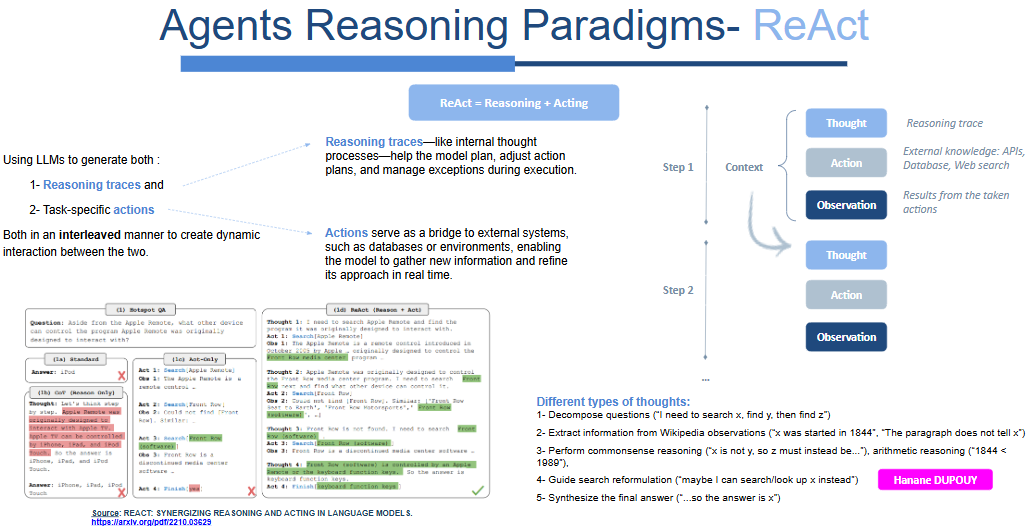

In [ ]:
from IPython.display import Image, display
display(Image(filename=path+'/reasoning_pattern_ReAct.png'))

⏰ Let's start building our RAG ReAct agent

We'll use the OpenAI LLMs and embedding model. the latest is used after retrieving data from pdfs and storing then in a vectorstore database.

In [ ]:
%pip install llama-index -q

In [3]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [4]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

Settings.llm = OpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY)
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small", api_key = OPENAI_API_KEY)

We'll upload 10k reports for Apple and Nvidia:

Apple 10K 2024: (https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q4/filing/10-Q4-2024-As-Filed.pdf)

Nvidia 10K 2024: (https://s201.q4cdn.com/141608511/files/doc_financials/2024/q4/1cbe8fe7-e08a-46e3-8dcc-b429fc06c1a4.pdf)

In [5]:
!wget 'https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q4/filing/10-Q4-2024-As-Filed.pdf' -O 'apple_10k.pdf'
!wget 'https://s201.q4cdn.com/141608511/files/doc_financials/2024/q4/1cbe8fe7-e08a-46e3-8dcc-b429fc06c1a4.pdf' -O 'nvidia_10k.pdf'

--2025-09-06 19:14:06--  https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q4/filing/10-Q4-2024-As-Filed.pdf
Resolving s2.q4cdn.com (s2.q4cdn.com)... 68.70.205.2, 68.70.205.4, 68.70.205.1, ...
Connecting to s2.q4cdn.com (s2.q4cdn.com)|68.70.205.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 963934 (941K) [application/pdf]
Saving to: ‘apple_10k.pdf’

apple_10k.pdf       100%[===================>] 941.34K  --.-KB/s    in 0.01s   

2025-09-06 19:14:06 (87.0 MB/s) - ‘apple_10k.pdf’ saved [963934/963934]

--2025-09-06 19:14:06--  https://s201.q4cdn.com/141608511/files/doc_financials/2024/q4/1cbe8fe7-e08a-46e3-8dcc-b429fc06c1a4.pdf
Resolving s201.q4cdn.com (s201.q4cdn.com)... 68.70.205.3, 68.70.205.4, 68.70.205.2, ...
Connecting to s201.q4cdn.com (s201.q4cdn.com)|68.70.205.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1074533 (1.0M) [application/pdf]
Saving to: ‘nvidia_10k.pdf’

nvidia_10k.pdf      100%[===================>]   1

In [ ]:
## If you cannot run the code above, you can do it this way:
# import requests

# url = 'https://s2.q4cdn.com/470004039/files/doc_earnings/2024/q4/filing/10-Q4-2024-As-Filed.pdf'
# response = requests.get(url)

# with open('apple_10k.pdf', 'wb') as f:
#     f.write(response.content)

## Documents Storing and Query Engine

If documents are already stored:

In [6]:
from llama_index.core import StorageContext, load_index_from_storage

try:
    storage_context = StorageContext.from_defaults(
        persist_dir="./data_storage/apple"
    )
    apple_index = load_index_from_storage(storage_context)

    storage_context = StorageContext.from_defaults(
        persist_dir="./data_storage/nvidia"
    )
    nvidia_index = load_index_from_storage(storage_context)

    index_loaded = True
except:
    index_loaded = False

Loading llama_index.core.storage.kvstore.simple_kvstore from ./data_storage/apple/docstore.json.


In [9]:
index_loaded

False

We load the PDFs in a VectoreStoreIndex if they are not already stored:
You will see a new folder named data_storage, containing two subfolders: apple and nvidia in which you have various files for index storage.

In [10]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex

if not index_loaded:
    # load data
    apple_docs = SimpleDirectoryReader(
        input_files=["./apple_10k.pdf"]
    ).load_data()
    nvidia_docs = SimpleDirectoryReader(
        input_files=["./nvidia_10k.pdf"]
    ).load_data()

    # build index
    apple_index = VectorStoreIndex.from_documents(apple_docs)
    nvidia_index = VectorStoreIndex.from_documents(nvidia_docs)

    # persist index
    apple_index.storage_context.persist(persist_dir="./data_storage/apple")
    nvidia_index.storage_context.persist(persist_dir="./data_storage/nvidia")

We build a query engine on the top of the vectorestore index for each 10K report:

* This query engine allows retrieve the most relevant chunks related to the user query.

* We have then 2 query engines : **apple_engine** and **nvidia_engine**.

In [ ]:
apple_engine = apple_index.as_query_engine(similarity_top_k=3)
nvidia_engine = nvidia_index.as_query_engine(similarity_top_k=3)

## Tools on the top of Query Engine

* The query engines are wrapped as tools that the ReAct agent can invoke during its reasoning process.

* 2 tools are created then "**apple_10k**" and "**nvidia_10k**".

In [ ]:
from llama_index.core.tools import QueryEngineTool

query_engine_tools = [
    QueryEngineTool.from_defaults(
        query_engine=apple_engine,
        name="apple_10k",
        description=(
              "Delivers insights and information about Apple's 2024 financial data. "
              "You'll provided with a detailed, plain text question to obtain the most relevant and precise responses"
        ),
    ),
    QueryEngineTool.from_defaults(
        query_engine=nvidia_engine,
        name="nvidia_10k",
        description=(
              "Delivers insights and information about Nvidia's 2024 financial data. "
              "You'll provided with a detailed, plain text question to obtain the most relevant and precise responses"
        ),
    ),
]

## ReAct Agent

We'll be using the built-in ReAct Agent:

* Both tools will be added to the ReAct Agent.

* Based on the user request, the ReAct agent will choose one of the tools or both tools to retrieve the adequate information from the reports.

* We also added a **context** to the agent, so it can memorize the past conversations.

In [ ]:
from llama_index.core.agent.workflow import ReActAgent
from llama_index.core.workflow import Context

agent = ReActAgent(
    tools=query_engine_tools,
    llm=OpenAI(model="gpt-4o-mini"),
)

ctx = Context(agent)

When asking: "What was the revenue of Nvidia in 2024? Comapre this value to 2023 revnue?"

➡ The agent understands that its needs to retrieve data from a tool: **Thought**

➡ The agent defines an **Action** which will call the nvidia_10k

➡ The agent calls "nvidia_10k" with the argument {"input": user query}

➡ We get the **observation** (= result) directly in the answer.

In [ ]:
from llama_index.core.agent.workflow import ToolCallResult, AgentStream

handler = agent.run("What was the revenue of Nvidia in 2024? Comapre this value to 2023 revnue?", ctx=ctx)

async for ev in handler.stream_events():
    if isinstance(ev, AgentStream):
        print(f"{ev.delta}", end="", flush=True)

response = await handler

Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: nvidia_10k
Action Input: {"input": "What was Nvidia's revenue in 2024 and how does it compare to the revenue in 2023?"}Thought: I can answer without using any more tools. I'll use the user's language to answer.
Answer: Nvidia's revenue in 2024 was $60.9 billion, which represents an increase of 126% compared to the revenue of $27.0 billion in 2023.

For this question, we are asking the agent to compare Nvidia and Apple revenues for 2024:

As you can see in the results, only **apple_10k** tool was called, because the agent has already in its context the Nvidia 2024 revenue.

The agent did a comparison between both values and even compute the ratio.

In [ ]:
from llama_index.core.agent.workflow import ToolCallResult, AgentStream

handler = agent.run("What was the revenue of Apple in 2024? Comapre it to Nvidia's revenue?", ctx=ctx)

async for ev in handler.stream_events():
    if isinstance(ev, AgentStream):
        print(f"{ev.delta}", end="", flush=True)

response = await handler

Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: apple_10k
Action Input: {'input': "What was Apple's revenue in 2024?"}Thought: I can answer without using any more tools. I'll use the user's language to answer.
Answer: Apple's revenue in 2024 was $391.035 billion, while Nvidia's revenue for the same year was $60.9 billion. This means Apple's revenue was significantly higher than Nvidia's, approximately 6.4 times greater.

# Readings

1- **Agentic AI Systems Applied to tasks in Financial Services: Modeling and model risk management crews**
https://arxiv.org/abs/2502.05439

2- AI Agents vs. Agentic AI: A Conceptual Taxonomy, Applications and Challenges
https://arxiv.org/pdf/2505.10468


3- AI Agents: Evolution, Architecture, and Real-World Applications
https://arxiv.org/html/2503.12687v1


4- LlamaIndex: Multi-Agent Research Workflow with AgentWorkflow
https://docs.llamaindex.ai/en/stable/examples/agent/agent_workflow_multi/


My Github repo: LLMs-in-Finance: https://github.com/hananedupouy/LLMs-in-Finance

* https://github.com/hananedupouy/LLMs-in-Finance/tree/main/Agents